## Imports

In [ ]:
!pip install -q datasets transformers evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import torch
from torch import nn
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, PreTrainedModel, PretrainedConfig
from transformers import EarlyStoppingCallback
import evaluate


In [ ]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
from torch.utils.data import DataLoader
rng = np.random.default_rng(42)

In [ ]:
# @title
import wandb

wandb.init(
    project="timestomping-detector-nano",
    name="obvious_and_subtle_detection"
)

eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁██
train/global_step,▁██
train/grad_norm,▁█
train/learning_rate,▁█
train/loss,█▁
eval/runtime,0.3989
eval/samples_per_second,4011.375
eval/steps_per_second,32.592


# Generate Data

### run 2

In [ ]:
def generate_benign(n=4000):
    rows = []
    for _ in range(n):
        base = rng.integers(1_577_836_800_000_000_000, 1_725_984_000_000_000_000)  # 2020–2025 in ns
        created = base
        modified = created + rng.integers(10_000_000_000, 3_600_000_000_000)
        accessed = modified + rng.integers(5_000_000_000, 3_600_000_000_000)
        entropy = rng.uniform(3.5, 7.5)
        rows.append([created, modified, accessed, modified - created, accessed - modified, entropy, 0])
    return rows

def generate_timestomp(n=4000, subtle_ratio=0.5):
    rows = []
    for _ in range(n):
        base = rng.integers(1_577_836_800_000_000_000, 1_725_984_000_000_000_000)
        created = base
        if rng.random() < subtle_ratio:
            modified = created - rng.integers(1_000_000_000, 30_000_000_000)
            accessed = modified + rng.integers(0, 10_000_000_000)
        else:
            modified = created - rng.integers(3_600_000_000_000, 86_400_000_000_000)
            accessed = modified - rng.integers(10_000_000_000, 600_000_000_000)
        entropy = rng.uniform(3.0, 6.5)
        rows.append([created, modified, accessed, modified - created, accessed - modified, entropy, 1])
    return rows

In [ ]:
benign = generate_benign()
timestomp = generate_timestomp()
data = benign + timestomp
random.shuffle(data)

X = [row[:-1] for row in data]
y = [row[-1] for row in data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def to_records(X, y):
    return [{"input_ids": row, "label": int(lbl)} for row, lbl in zip(X, y)]

train_ds = Dataset.from_list(to_records(X_train, y_train)).rename_column("label", "labels")
test_ds  = Dataset.from_list(to_records(X_test, y_test)).rename_column("label", "labels")

## Model creation

In [ ]:
import torch.nn as nn

class TabularMLP(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            # ⬆️ Increased width from 64 → 128
            # Rationale: more neurons in the first layer give the model capacity to learn richer
            # interactions between features (especially useful with nanosecond deltas + entropy).
            nn.Linear(input_dim, 128),

            # ⬆️ Added BatchNorm
            # Rationale: normalizes activations, stabilizes training, reduces sensitivity to scale.
            nn.BatchNorm1d(128),

            nn.ReLU(),

            # ⬆️ Increased dropout from 0.2 → 0.3
            # Rationale: stronger regularization to prevent overfitting with the wider layer.
            nn.Dropout(0.25),

            # ⬆️ Second hidden layer widened from 32 → 64
            # Rationale: smoother dimensionality reduction, avoids bottleneck too early.
            nn.Linear(128, 64),

            # ⬆️ Added BatchNorm here too
            # Rationale: keeps activations stable across deeper layers.
            nn.BatchNorm1d(64),

            nn.ReLU(),

            # ⬆️ Dropout kept at 0.2
            # Rationale: lighter regularization here since the layer is narrower.
            nn.Dropout(0.15),

            # ⬆️ Retained a 32-unit layer
            # Rationale: acts as a compact representation before output, similar to your original.
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.05),

            # ⬆️ Output layer unchanged
            # Rationale: still maps to 2 classes (benign vs. timestomp/wiped).
            nn.Linear(32, num_classes)
        )
    def forward(self, input_ids, labels=None):
        logits = self.net(input_ids)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}


In [ ]:
# ✅ Metrics setup
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

In [ ]:
args = TrainingArguments(
  output_dir="./timestomp_detect_nano",  # Where checkpoints/logs are saved
  eval_strategy="epoch",   # Evaluate after each epoch
  save_strategy="epoch",   # Save model after each epoch

  learning_rate=8e-4,       # 🔹 increased learning rate
  lr_scheduler_type="cosine",   # 🔹 added scheduler
  per_device_train_batch_size=64,
  per_device_eval_batch_size=128,
  num_train_epochs=200,
  weight_decay=0.02,
  logging_steps=50,
  warmup_ratio=0.1,
  gradient_accumulation_steps=1,
  remove_unused_columns=False,
  load_best_model_at_end=True,       # restore best checkpoint
  metric_for_best_model="f1",        # prioritize balanced detection
  greater_is_better=True,
  dataloader_pin_memory=False
)

input_dim = len(train_ds[0]["input_ids"])  # number of features
hf_model = TabularMLP(input_dim=input_dim, num_classes=2)

In [ ]:
trainer = Trainer(
    model=hf_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

In [ ]:
metrics = trainer.evaluate()
print(metrics.keys())

dict_keys(['eval_loss', 'eval_model_preparation_time', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second'])


## Training

In [ ]:
trainer.train()
metrics = trainer.evaluate()
metrics

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.703100,0.673618,0.000600,0.470625,0.413043,0.470625,0.365602
2,0.576000,0.521113,0.000600,0.895000,0.897234,0.895000,0.894852
3,0.406800,0.344453,0.000600,0.944375,0.949693,0.944375,0.944210
4,0.260700,0.219296,0.000600,0.940000,0.946429,0.940000,0.939783
5,0.181000,0.135707,0.000600,0.956875,0.960299,0.956875,0.956795
6,0.152300,0.107595,0.000600,0.961875,0.964576,0.961875,0.961820
7,0.142000,0.106924,0.000600,0.958125,0.961361,0.958125,0.958051
8,0.129600,0.093415,0.000600,0.963750,0.966200,0.963750,0.963702
9,0.111000,0.083654,0.000600,0.965000,0.967290,0.965000,0.964957
10,0.118400,0.105580,0.000600,0.957500,0.960829,0.957500,0.957423


{'eval_loss': 0.03258300572633743,
 'eval_model_preparation_time': 0.0006,
 'eval_accuracy': 0.99125,
 'eval_precision': 0.9914004914004915,
 'eval_recall': 0.99125,
 'eval_f1': 0.9912493300268301,
 'eval_runtime': 0.1334,
 'eval_samples_per_second': 11990.363,
 'eval_steps_per_second': 97.422,
 'epoch': 49.0}

## AI Detection

In [ ]:
benign_samples = test_ds.filter(lambda x: x["labels"] == 0).select(range(100))
timestomp_samples = test_ds.filter(lambda x: x["labels"] == 1).select(range(100))

print(benign_samples[:3])
print(timestomp_samples[:3])

Filter:   0%|          | 0/1600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'input_ids': [[0.6740756687367666, 0.6743720526466724, 0.6743530938919984, 0.5350700100486473, -0.6566852903541992, 0.22964797506202012], [0.7125955223278378, 0.7129196483823319, 0.7129813934528163, 0.5854617406710588, 2.1273267571484067, 2.061125828587572], [1.6407896602356862, 1.641123256599814, 1.6411476777389506, 0.5911928112932908, 0.836077720396641, 1.5900453608731113]], 'labels': [0, 0, 0]}
{'input_ids': [[-0.18912067048758435, -0.18888357003020897, -0.18890305695672444, 0.43717484724813166, -0.6715317876441077, -1.3986577622938745], [0.8990086857533512, 0.8979297790097657, 0.8979042875343339, -1.9898110823419972, -0.8829284403018667, -0.06511242109650657], [1.4706414522944848, 1.4705523442848756, 1.47052819014373, -0.18184585518774765, -0.8390308875061537, 0.5629241229849236]], 'labels': [1, 1, 1]}


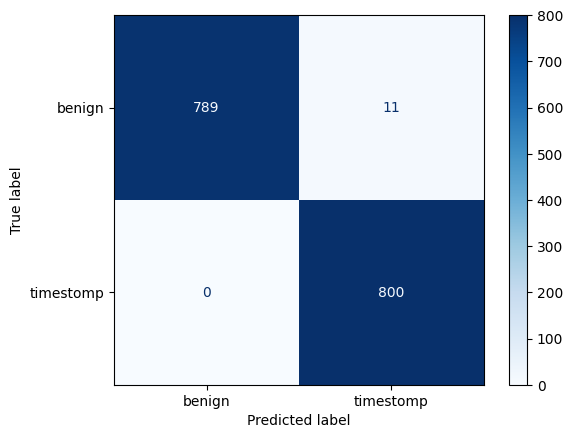

In [244]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = (y_scores >= 0.75).astype(int)

#y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign","timestomp"])
disp.plot(cmap="Blues")
plt.show()

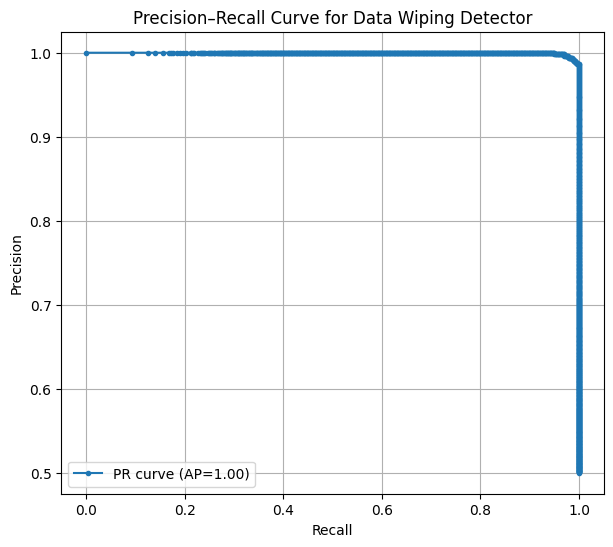

In [240]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


# Run evaluation on your test set
predictions = trainer.predict(test_ds)

# predictions.predictions are the raw logits
logits = predictions.predictions
y_true = predictions.label_ids

import torch
import numpy as np

# Convert logits → probabilities for class 1 (wiped)
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
y_scores = probs[:, 1]   # probability of "wiped"


precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve for Data Wiping Detector')
plt.legend()
plt.grid(True)
plt.show()

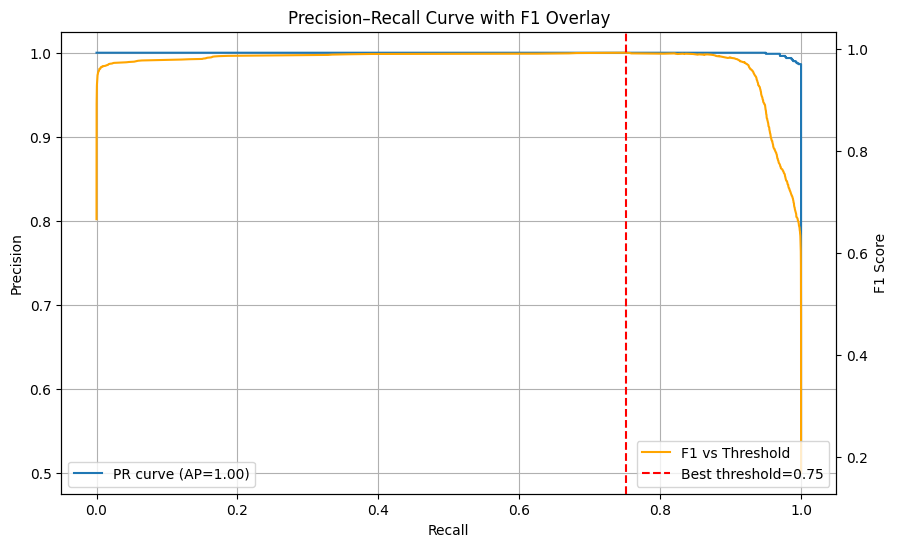

Best threshold: 0.75215316
Best F1: 0.9931719428926132


In [241]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# y_true: ground truth labels (0=benign, 1=wiped)
# y_scores: predicted probabilities for class 1 (wiped)

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

# Compute F1 at each threshold
f1_scores = []
for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot PR curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve with F1 Overlay')
plt.legend()
plt.grid(True)

# Plot F1 vs threshold on a secondary axis
plt.twinx()
plt.plot(thresholds, f1_scores, color='orange', label='F1 vs Threshold')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold={best_threshold:.2f}')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')

plt.show()

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)

## Rule based detection

In [ ]:
def rule_based_detect(row):
    """
    row: [created, modified, accessed, delta1, delta2, entropy]
    Returns 1 if timestomp anomaly detected, else 0 (benign).
    """
    created, modified, accessed, d1, d2, entropy = row

    # Rule 1: progression anomaly
    if modified < created or accessed < modified:
        return 1  # timestomp

    # Rule 2: negative deltas
    if d1 < 0 or d2 < 0:
        return 1

    # Rule 3: subtle anomalies
    TEN_MS = 10_000_000  # 10 ms in ns
    if (entropy < 2.5 or entropy > 7.9) and (d1 == 0 or d2 == 0):
      return 1

    return 0  # benign

Rule-based accuracy: 0.889375


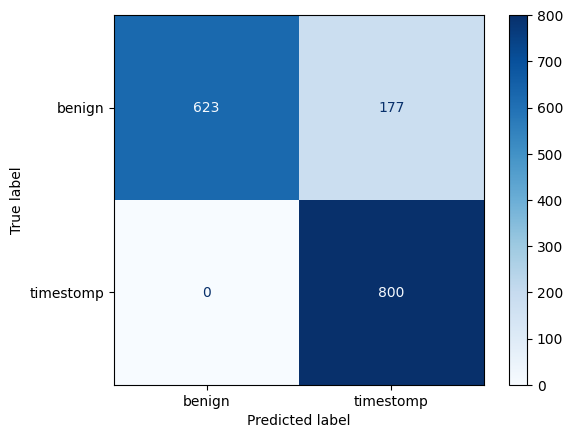

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Apply rule-based detection
y_pred_rule = [rule_based_detect(x) for x in X_test]

# Accuracy
acc = accuracy_score(y_test, y_pred_rule)
print("Rule-based accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rule, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign","timestomp"])
disp.plot(cmap="Blues")
plt.show()

In [ ]:
import torch

# Save just the model weights
torch.save(hf_model.state_dict(), "timestomp_model_nano_cutoff.pt")
torch.save(hf_model, "timestomp_model_nano_cutoff_full.pt")


# Save the scaler too (using joblib or pickle)
import joblib
joblib.dump(scaler, "scaler_nano_cutoff.pkl")


['scaler_nano_cutoff.pkl']

In [ ]:
from google.colab import files
files.download("timestomp_model_nano_cutoff.pt")
files.download("timestomp_model_nano_cutoff_full.pt")
files.download("scaler_nano_cutoff.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sum(p.numel() for p in hf_model.parameters())

11682

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp timestomp_model.pt /content/drive/MyDrive/
# !cp scaler.pkl /content/drive/MyDrive/

Mounted at /content/drive
